<a href="https://colab.research.google.com/github/fsommers/ICMR24/blob/main/ICRM24_LayoutLMv3_2_CreateDataset.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Create a PyTorch Dataset for the Custom Document Images

While LayoutLMv3Processor conveniently includes the option to perform OCR on the input image, in practice it's more effective to preprocess the training data documents. Since the OCR process introduces significantly processing time to the pipeline, OCR'ing images on demand would consume additional expensive GPU minutes.

In this notebook, we will prepare our document data, and define a PyTorch train and test dataset for our data and save these datasets in the `DOC_DATA` directory on the Google Drive.

We prepare the document data as follows:

* Extract the first page of each PDF document. We save this image with the same base filename as the PDF, but with a JPG file extension.

* In addition, we OCR each page, and save the result words and corresponding bounding boxes as a JSON data file. This file share the same base file name with the PDF images, too, but the file extension is now .json.

* Define a PyTorch Dataset. This dataset returns the prepared document data examples the Dataloader that then provides the examples to the model.

Again, we need to install Tesseract OCR and it's Python bindings:

In [ ]:
! apt -qq install tesseract-ocr
! apt -qq install libtesseract-dev

In [ ]:
!pip -qqq install pytesseract
!pip -qqq install Pillow
!pip -qqq install PyMuPDF

As in the previous notebook, this example assumes that the custom document images are stored on Google Drive, in a DOC_EXAMPLES/TRAINING subdirectory.

For each document label, there is a corresponding subdirectory named as the document label. Currently, there are 8 labels:

* AZCONTRACT
* BOOKSHEET
* BUYERSGUIDE
* CACONTRACT
* CREDITAPP
* INSURANCE
* NVCONTRACT

In each directory there are PDF documents.

We'll import some libraries first:

In [ ]:
import sys
from pathlib import Path
from tqdm import tqdm
from pathlib import Path
from typing import List

import fitz
import numpy as np
import pandas as pd
import cv2
import pytesseract
from PIL import Image, ImageDraw, ImageFont
import matplotlib.pyplot as plt

import json

import torch
import torchvision.transforms as T
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split

%matplotlib inline

from google.colab import drive
drive.mount('/content/drive')

Some environment variables:

In [ ]:
BASE_DIR = Path('/content/drive/MyDrive')

EXAMPLES_DIR = Path(BASE_DIR / 'DOC_EXAMPLES' / 'TRAINING')
UNSEEN_DIR = Path(BASE_DIR / 'DOC_EXAMPLES' / 'UNSEEN')
DATASET_DIR = Path(BASE_DIR / 'DOC_DATA')
LOG_DIR = Path(BASE_DIR / 'DOC_LOGS')
MODELS_DIR = Path(BASE_DIR / 'DOC_MODELS')


DOCUMENT_LABELS = [
    'AZCONTRACT',
    'BUYERSGUIDE',
    'CACONTRACT',
    'CREDITAPP',
    'NVCONTRACT',
    'BOOKSHEET',
    'INSURANCE'
]

# The assumption is that training documents are pre-categorized and collected into subdirectories,
# with directory names corresponding to the document class names
training_dirs = { doc_label: EXAMPLES_DIR.joinpath(doc_label) for doc_label in DOCUMENT_LABELS }
print(training_dirs)

unseen_dirs = { doc_label: UNSEEN_DIR.joinpath(doc_label) for doc_label in DOCUMENT_LABELS }
print(unseen_dirs)

# We will need to keep a stable ordering of the class labels.
DOCUMENT_CLASSES = sorted(training_dirs.keys())
print(DOCUMENT_CLASSES)

import PIL.Image
PIL.Image.MAX_IMAGE_PIXELS = 503120000 # this is needed in case of larger images

These functions are to take an PDF file, obtain the first PDF pages as JPG images, save that image, OCR that images, and finally to save the OCR results.

In [ ]:
def save_page_as_jpeg(im_file: Path, page: int):
  """
  Convert the specified page of the given PDF to a JPG images.
  Save the JPG with the same file name as the original PDF, but with a .jpg suffix.
  """
  with fitz.open(im_file) as pdf:
    pix = pdf.get_page_pixmap(page, dpi=300)
    pix.save(im_file.with_suffix('.jpg'))

TESS_OPTIONS = "--psm 3" # Automatic page segmentation for Tesseract

def ocr_page(jpg_file: Path) -> dict:
  """
  OCR a given image. Return a dictionary of words and the bounding boxes
  for each word. For each word, there is a corresponding bounding box.
  """
  with Image.open(jpg_file) as image:
    ocr_df = pytesseract.image_to_data(image, output_type='data.frame', config=TESS_OPTIONS)
    ocr_df = ocr_df.dropna().reset_index(drop=True)
    float_cols = ocr_df.select_dtypes('float').columns
    ocr_df[float_cols] = ocr_df[float_cols].round(0).astype(int)
    ocr_df = ocr_df.replace(r'^\s*$', np.nan, regex=True)
    ocr_df = ocr_df.dropna().reset_index(drop=True)

    words = list(ocr_df.text)
    words = [str(w) for w in words]

    coordinates = ocr_df[['left', 'top', 'width', 'height']]
    boxes = []
    for i, row in coordinates.iterrows():
        x, y, w, h = tuple(row)
        actual_box = [x, y, x + w, y + h]
        boxes.append(actual_box)

    assert len(words) == len(boxes)
    return {"bbox": boxes, "words": words}

def pdf_to_jpeg(files_dir: dict, page: int):
  """
  Convert the specified page of each PDF file to JPG, in each folder inside the specified directory.
  Page numbers start with 0
  This will run for a long time.
  """
  for label, p in files_dir.items():
    for pdf in tqdm(list(p.glob('*.pdf'))):
      save_page_as_jpeg(pdf, page)

def jpeg_to_ocr(files_dir: dict):
  """
  OCR each JPG image in the specified directory, and save the results in a JSON file.
  This will run a long time.
  """
  for label, p in files_dir.items():
    for jpg in tqdm(list(p.glob('*.jpg'))):
      ocr_result = ocr_page(jpg)
      with jpg.with_suffix(".json").open("w") as f:
        json.dump(ocr_result, f)

With these methods in place, we first create a JPG image of the first page of each example PDF, resulting in a JPG file with the same file name prefix as the PDF.

In [ ]:
# NOTE: This will run for a while.
# Run this once on the training_dirs and on the unseen_dirs
# pdf_to_jpeg(training_dirs, 0)
# pdf_to_jpeg(unseen_dirs, 0)

100%|██████████| 100/100 [01:00<00:00,  1.65it/s]


Next, we OCR each JPG images, and save the OCR results in a file with the same name as the original PDF but with the .json suffix.

In [ ]:
# NOTE This will run for a while.
# Run this once on the training_dirs and once on the unseen_dirs
# jpeg_to_ocr(training_dirs)
# jpeg_to_ocr(unseen_dirs)

100%|██████████| 100/100 [04:43<00:00,  2.83s/it]


To visually inspect the OCR results, we display the original image and the OCR-extracted text side-by side.

In [ ]:
font_path = Path(cv2.__path__[0]) / "qt/fonts/DejaVuSansCondensed.ttf"
#print(font_path.exists())
font = ImageFont.truetype(str(font_path), size=26)

def side_by_side(image_path: Path):
  """
  Open the specified image and the corresponding JSON OCR metadata file.
  Display the image on the left side with the OCR bounding boxes.
  Display just the OCR-extracted text on the right side.
  """
  left_image = Image.open(image_path)
  right_image = Image.new("RGB", left_image.size, (255, 255, 255))

  left_draw = ImageDraw.Draw(left_image)
  right_draw = ImageDraw.Draw(right_image)

  fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(28, 28))

  with image_path.with_suffix(".json").open("r") as f:
    ocr_data = json.load(f)

  i = 1
  for bbox, words in zip(*ocr_data.values()):
    left_draw.rectangle(
        [
            bbox[0],
            bbox[1],
            bbox[2],
            bbox[3],
        ],
        outline='blue',
        width=2
      )
    left, top, right, bottom = bbox
    left_draw.text((right + 5, top), text=str(i + 1), fill='red', font=font)
    right_draw.text((left, top), text=words, fill='black', font=font)
    i = i + 1

  ax1.imshow(left_image)
  ax2.imshow(right_image)
  ax1.axis('off')
  ax2.axis('off')

In [ ]:
# Display the first AZCONTRACCT file
image_path = list(training_dirs['AZCONTRACT'].glob('*.jpg'))[0]
side_by_side(image_path)

## Evaluating an example with the pre-trained model

As before, let's provide an example image to the model and observe the output.
The LayoutLMv3 model consumes the page's text, the bounding boxes for each word, and the page image. The model's forward pass then then returns a prediction.

This time, we tell the feature extractor to not use OCR. We'll instead provide our pre-processed data:

In [ ]:
from transformers import LayoutLMv3FeatureExtractor, LayoutLMv3TokenizerFast, LayoutLMv3Processor, LayoutLMv3ForSequenceClassification

# Not using OCR
feature_extractor = LayoutLMv3FeatureExtractor(apply_ocr=False)
tokenizer = LayoutLMv3TokenizerFast.from_pretrained("microsoft/layoutlmv3-base")
processor = LayoutLMv3Processor(feature_extractor, tokenizer)

LayoutLMv3 model expects bounding box coordinates to be normalized to a 1000x1000 image. Therefore, we need to scale the bounding boxes from the OCR results:

In [ ]:
def scale_bounding_box(box: List[int], w_scale: float = 1.0, h_scale: float = 1.0):
  return [
      int(box[0] * w_scale),
      int(box[1] * h_scale),
      int(box[2] * w_scale),
      int(box[3] * h_scale)
  ]

def prepare_image(im_path):
  """
  Prepare an image to be passed to the processor.
  The image, the words, and the scaled bounding boxes for LayoutLM are returned.
  """
  img = Image.open(im_path).convert('RGB')
  width, height = img.size
  width_scale = 1000 / width
  height_scale = 1000 / height
  with im_path.with_suffix(".json").open("r") as f:
    ocr_data = json.load(f)
  words = []
  boxes = []
  for w, b in zip(ocr_data["words"], ocr_data["bbox"]):
    words.append(w)
    boxes.append(scale_bounding_box(b, width_scale, height_scale))

  assert len(words) == len(boxes)
  for bo in boxes:
    for z in bo:
      if (z > 1000):
        raise

  return img, words, boxes

We now use these helper functions to encode an image, and provide it to the processor. In addition to the page image, we must now also provide the sequence of words and the word bounding boxes.

As in the previous notebook, we need to truncate our input sequences to 512 tokens:

In [ ]:
image_path = list(training_dirs['AZCONTRACT'].glob('*.jpg'))[0]
image, words, bbox = prepare_image(image_path)

encoding = processor(
    image,
    words,
    boxes=bbox,
    max_length=512,
    padding="max_length",
    truncation=True,
    return_tensors="pt"
)

print(encoding.keys())

print(f"""
 input_ids: {list(encoding["input_ids"].squeeze().shape)}
 bbox: {list(encoding['bbox'].squeeze().shape)}
 pixel_values: {list(encoding['pixel_values'].squeeze().shape)}
 image size: {image.size}
""")

dict_keys(['input_ids', 'attention_mask', 'bbox', 'pixel_values'])

 input_ids: [512]
 bbox: [512, 4]
 pixel_values: [3, 224, 224]
 image size: (2540, 4244)



The pixel_values for image embedding indducates 224x224 squares, 3 channels.
The bbox elements have 4 values: left, top, right, bottom.

Let's take a look at the tokenizer results and the image:

['ĠA', 'AW', 'Ġ5', '53', '-', 'AZ', '-', 'ARB', '-', 'eps', '-', '14', 'Ġ11', '/', '23', 'ĠR', 'ETA', 'IL', 'ĠINST', 'ALL']
 AAW 553-AZ-ARB-eps-14 11/23 RETAIL INSTALL
torch.Size([3, 224, 224])


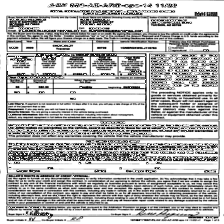

In [ ]:
tokens = tokenizer.convert_ids_to_tokens(
    encoding["input_ids"][0],
    skip_special_tokens=True
)
print(tokens[:20])

print(tokenizer.convert_tokens_to_string(tokens[:20]))

image_data = encoding["pixel_values"][0]
print(image_data.shape)
transform = T.ToPILImage()
transform(image_data)

As in the previous notebook, let's pass this example to the model:

In [ ]:
model = LayoutLMv3ForSequenceClassification.from_pretrained("microsoft/layoutlmv3-base", output_hidden_states=True)
outputs = model(**encoding)
print(outputs.logits)


## Create a Pytorch dataset

As we confirmed that the model is able to process our encoded inputs, we now create a PyTorch dataset for the training and test examples, and save this dataset on the Google Drive, under the DOC_DATA directory:

In [ ]:
class DocumentClassificationDataset(Dataset):

  def __init__(self, image_paths, processor):
    self.image_paths = image_paths
    self.processor = processor

  def __len__(self):
    return len(self.image_paths)

  def __getitem__(self, item):
    image_path = self.image_paths[item]
    image, words, bbox = prepare_image(image_path)
    encoding = self.processor(
        image,
        words,
        boxes=bbox,
        max_length=512,
        padding="max_length",
        truncation=True,
        return_tensors="pt"
    )

    # The document file's parent directory name is the label for the file:
    label = DOCUMENT_CLASSES.index(image_path.parent.name)

    return dict(
        input_ids=encoding['input_ids'].flatten(),
        attention_mask=encoding['attention_mask'].flatten(),
        bbox=encoding['bbox'].flatten(end_dim=1),
        pixel_values=encoding['pixel_values'].flatten(end_dim=1),
        labels=torch.tensor(label, dtype=torch.long)
    )


We now iterate through all the images in all subdirectories under the training document directory, and create a train and test split:

In [ ]:
selected_images = []
for p in training_dirs.values():
  imp = list(p.glob('*.jpg'))
  selected_images.extend(imp)

print(f"{len(selected_images)} images")

train_images, test_images = train_test_split(selected_images, test_size=.2)

3497 images


We create the two datasets, check if the datasets look fine, and then save the datasets to disk:

In [ ]:
train_dataset = DocumentClassificationDataset(train_images, processor)
test_dataset = DocumentClassificationDataset(test_images, processor)

In [ ]:
for item in train_dataset:
  print(item['bbox'].shape)
  print(item['pixel_values'].shape)
  print(item['labels'].item())
  break

In [ ]:
torch.save(train_dataset, DATASET_DIR / 'train_dataset')
torch.save(test_dataset, DATASET_DIR / 'test_dataset')